In [3]:
%load_ext autoreload
%matplotlib inline
from pathlib import Path
from packaging import version
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy import stats
import tensorboard as tb
import traceback

In [4]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.15.2


In [5]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


# https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
# modified to create correct indexing behavior
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame

    Parameters
    ----------
    path : str
        path to tensorflow log file

    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": [], "index": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        global_increment = 0
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            index = np.arange(len(step)) + global_increment
            r = {"metric": [tag] * len(step), "value": values, "step": step, "index": index}
            r = pd.DataFrame(r, index=index)
            runlog_data = pd.concat([runlog_data, r])
            global_increment += len(step)
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [6]:
def postprocess_df(df):
    rx = re.compile(r"/(\d+)/")

    for ix, (name, row) in enumerate(df.iterrows()):
        island_id = rx.findall(row.loc['metric'])[0]
        df.at[name, 'island_id'] = int(island_id)
        df.at[name, 'island_type'] = row.loc['metric'].split('/')[0]


    df = df.astype({
        'island_id': int,
    })
    return df

In [7]:
def rows_like(sf: pd.DataFrame, search_term: str, column: str) -> list:
    bool_result = []
    for val in sf[column]:
        if search_term in val:
            bool_result.append(True)
        else:
            bool_result.append(False)
    
    return np.asarray(bool_result, dtype=bool)

In [8]:
def plot_col(f, ax, df, island_id, key, printable=None, reduction='none'):
    # f, ax = plt.subplots(1, 1)
    x = []
    y = []
    y_err = []
    for name, row in df[df['island_id'] == island_id].sort_values(by='step').iterrows():
        epoch = int(row['step'])
        data = row[key]
        if isinstance(data, float):
            x.append(epoch)
            y.append(data)
        else:
            # island_iter x (uda_iter * sgd_iter)
            data = np.asarray(data)
            if reduction == 'mean':
                x.append(epoch)
                data_mean = data.mean()
                data_std = data.std()
                y.append(data_mean)
                y_err.append(data_std)
            else:
                print(data.shape)
                num_steps = np.prod(data.shape)
                print(num_steps)
                x.extend( np.linspace(start=0, stop=1-(1./num_steps), num=num_steps) + epoch )
                print(x)
                data = data.reshape(np.prod(data.shape))
                y.extend(data)
                y_err.extend(np.zeros_like(data))

    y = np.asarray(y)
    y_err = np.asarray(y_err)

    ax.plot(x, y, label=key if not printable else printable)

    if len(y_err):
        ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)

    if True in np.isnan(y):
        ax.set_title(f"Island {int(island_id)} (NaN detected)", c='r')
    else:
        ax.set_title(f"Island {int(island_id)}")

    ax.set_xlabel('epochs')
    ax.legend()
    # plt.show()
    # plt.close()

## from tensor event

In [16]:
from pathlib import Path

MIN_FILE_SIZE_B = 100
run_id = 0
root_dir = Path(f"/data/petabyte/wgarcia/save/mo-marl/autogen/102824-161844/1000/{run_id}/search/island/")
candidates = root_dir.glob("events.out.tfevents*")
candidates = [c for c in candidates if c.stat().st_size > MIN_FILE_SIZE_B]
if len(candidates) == 0:
    raise RuntimeError("No file big enough!")

file_path = list(candidates)[0].as_posix()

df = tflog2pandas(file_path).astype({
    'index': int,
    'step': int,
})
df = df.set_index("index")

In [17]:
df[:20]

,metric,value,step
index,,,
0,island/0/algorithm/add_migrants_to_buffer/upda...,-0.121942,0
1,island/0/algorithm/add_migrants_to_buffer/upda...,-0.114776,1
2,island/0/algorithm/add_migrants_to_buffer/upda...,-0.175228,0
3,island/0/algorithm/add_migrants_to_buffer/upda...,-0.170852,1
4,island/0/algorithm/add_migrants_to_buffer/upda...,-0.242834,0
5,island/0/algorithm/add_migrants_to_buffer/upda...,-0.242834,1
6,island/0/algorithm/add_migrants_to_buffer/upda...,1600.595825,0
7,island/0/algorithm/add_migrants_to_buffer/upda...,2141.062500,1
8,island/0/algorithm/add_migrants_to_buffer/upda...,1180.749390,0


In [18]:
df['metric'].unique()

array(['island/0/algorithm/add_migrants_to_buffer/update_archives/archive/fitness_max',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/fitness_mean',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/fitness_min',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/novelty_max',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/novelty_mean',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/novelty_min',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/population_change',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/population_total',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/migrants_in_queue',
       'island/0/epoch',
       'island/0/population_server/set_population/current_population'],
      dtype=object)

In [20]:
df = postprocess_df(df)

df.iloc[1]

metric         island/0/algorithm/add_migrants_to_buffer/upda...
value                                                  -0.114776
step                                                           1
island_id                                                      0
island_type                                               island
Name: 1, dtype: object

In [30]:
islands_only_df = df[
    (rows_like(df, "actor_loss_mean", "metric")) & (df["island_type"] == "island")
]

for (metric, island_id), isf in islands_only_df.groupby(["metric", "island_id"]):
    isf[metric] = isf["value"]
    f, ax = plt.subplots(1, 1)
    plot_col(f, ax, isf, island_id, metric, '/'.join(metric.split('/')[-2:]))
    

,metric,value,step,island_id,island_type
index,,,,,


## results.json

In [27]:
import json

from collections import defaultdict

run_id = 2
root_dir = Path(f"/data/petabyte/wgarcia/save/mo-marl/autogen/102524-214456/1000/{run_id}/search/island/")
results_path = root_dir / "results.json"

fmt = "tensorboard"

if fmt == "pd":
    with results_path.open("r") as f:
        data = defaultdict(list)
        # json1
        # json2
        # ...
        # jsonN
        jl = f.readlines()
        for ix, j in enumerate(jl):
            results = json.loads(j)
            # |- k1  k2  k3 -|
            # |  v1  v2  v3 -|
            for k, v in results.items():
                data[k].append(v)
            
            data["index"].append(f"{ix}")

    df = pd.DataFrame(data=data)

elif fmt == "tensorboard":
    island_type = "island"
    island_id = str(0)
    prefix = f"{island_type}/{island_id}/"

    with results_path.open("r") as f:
        data = defaultdict(list)
        # json1
        # json2
        # ...
        # jsonN
        jl = f.readlines()
        ix = 0
        for j in jl:
            results = json.loads(j)
                
            # |- metric   value   step -|
            # |  abc/0/b  0.000     2  -|
            for k, v in results.items():
                if isinstance(v, list) and len(v) == 0: continue
                if k == f'{prefix}epoch': continue
                data['metric'].append(k)
                data['step'].append(results[f'{prefix}epoch'])
                data['value'].append(v)
                data['index'].append(ix)
                ix += 1

        df = pd.DataFrame(data=data)
        df = postprocess_df(df)
else:
    raise ValueError()

In [28]:
# df = postprocess_df(df)
display(df[-20:])
if fmt == "tensorboard":
    display(df['metric'].unique())

,metric,step,value,index,island_id,island_type
86,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[241.89625549316406, 241.89373779296875, 241.8...",86,0,island
87,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[241.3744659423828, 241.37353515625, 241.37234...",87,0,island
88,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[240.68824768066406, 240.68870544433594, 240.6...",88,0,island
89,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[0.20000000298023224, 0.20000000298023224, 0.2...",89,0,island
90,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[0.20000000298023224, 0.20000000298023224, 0.2...",90,0,island
91,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[0.20000000298023224, 0.20000000298023224, 0.2...",91,0,island
92,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[0.0, 0.03305719792842865, 0.00957758259028196...",92,0,island
93,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[0.0, 0.013921864330768585, 0.0057173799723386...",93,0,island
94,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[0.0, 0.004503246862441301, 0.0034259983804076...",94,0,island
95,island/0/algorithm/evolve/info/team/0/agent/de...,1,"[10.227474212646484, 9.888077735900879, 9.5699...",95,0,island


array(['island/0/algorithm/add_migrants_to_buffer/update_archives/archive/fitness_max',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/fitness_mean',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/fitness_min',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/heatmap_max',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/heatmap_mean',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/heatmap_min',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/novelty_max',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/novelty_mean',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/novelty_min',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/population_change',
       'island/0/algorithm/add_migrants_to_buffer/update_archives/archive/population_total',
       'island/0/a

(200,)
200
[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.17500000000000002, 0.18, 0.185, 0.19, 0.195, 0.2, 0.20500000000000002, 0.21, 0.215, 0.22, 0.225, 0.23, 0.23500000000000001, 0.24, 0.245, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.28500000000000003, 0.29, 0.295, 0.3, 0.305, 0.31, 0.315, 0.32, 0.325, 0.33, 0.335, 0.34, 0.34500000000000003, 0.35000000000000003, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.4, 0.405, 0.41000000000000003, 0.41500000000000004, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47000000000000003, 0.47500000000000003, 0.48, 0.485, 0.49, 0.495, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.5650000000000001, 0.5700000000000001, 0.5750000000000001, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.61, 0.615, 0.62, 

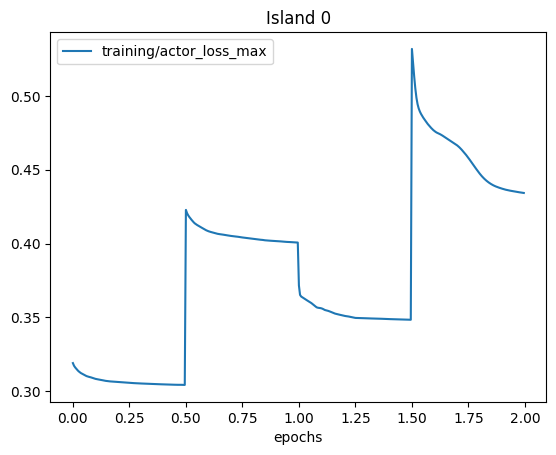

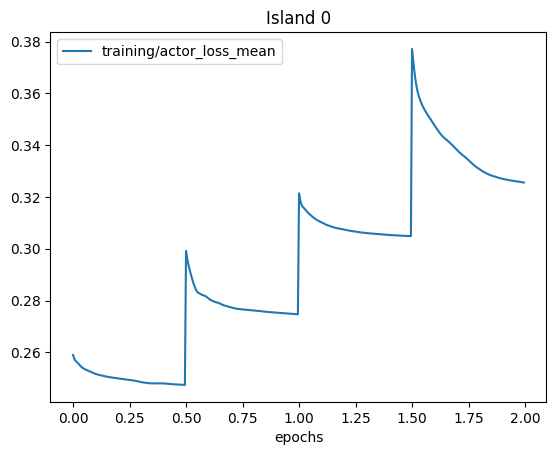

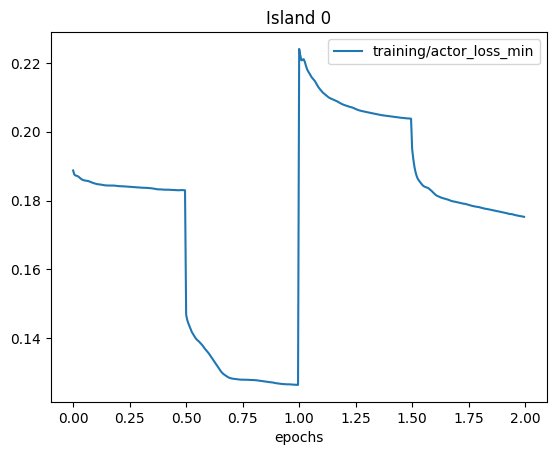

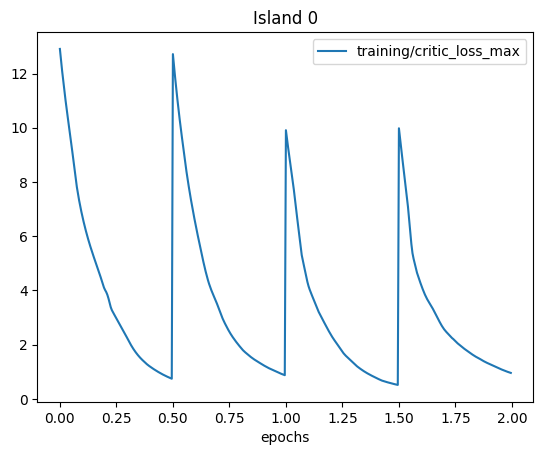

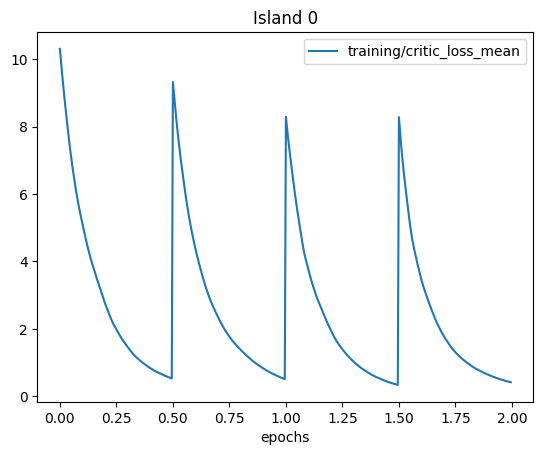

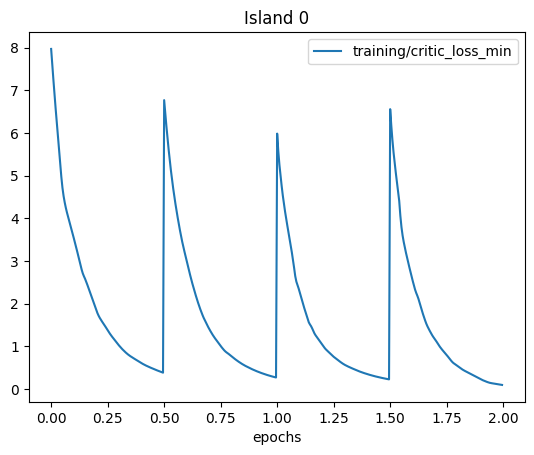

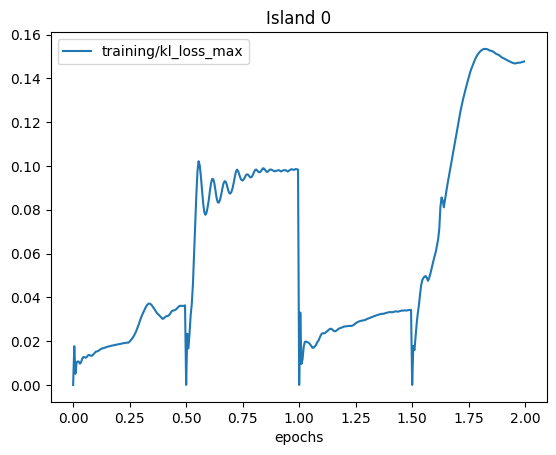

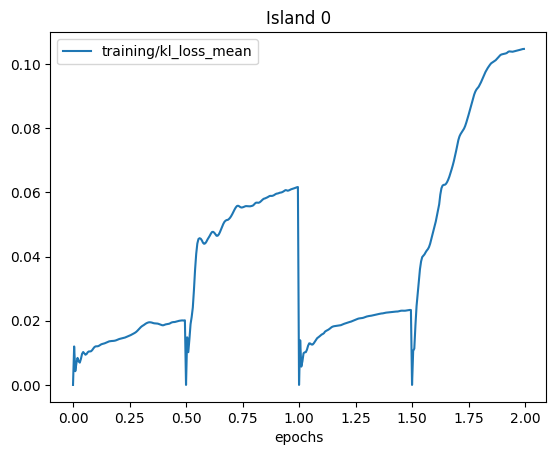

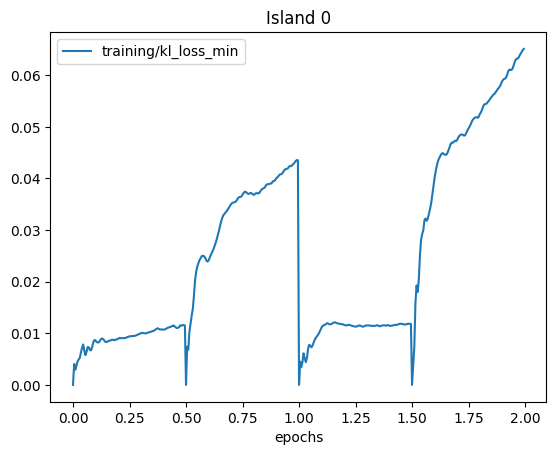

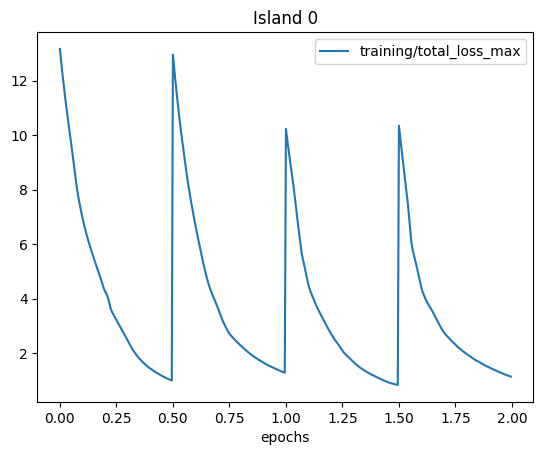

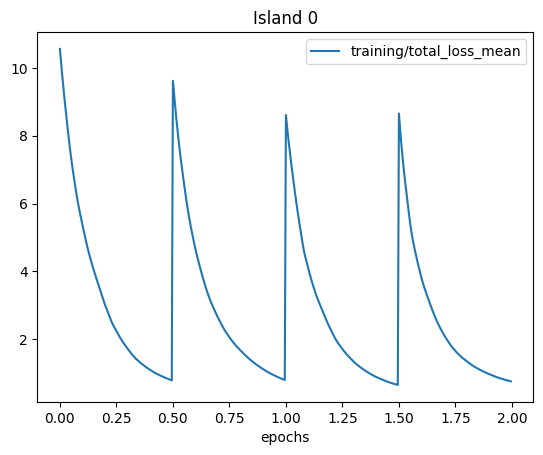

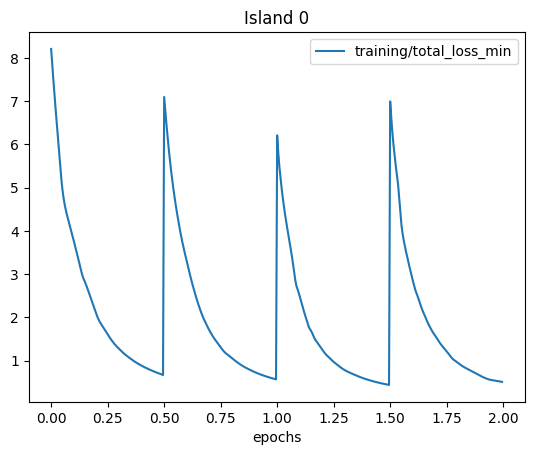

In [29]:
islands_only_df = df[
    (rows_like(df, "loss", "metric")) & (df["island_type"] == "island")
]

for (metric, island_id), isf in islands_only_df.groupby(["metric", "island_id"]):
    isf[metric] = isf["value"]
    f, ax = plt.subplots(1, 1)
    plot_col(f, ax, isf, island_id, metric, '/'.join(metric.split('/')[-2:]), reduction='none')
    

In [14]:
def metric_path_to_island_meta(s: str):
    ## s: island/0/aaaaa/bbb/ccccc
    rx = re.compile(r"/(\d+)/")
    island_id = rx.findall(s)[0]  # use first match
    rt = re.compile(r"^(\w+)\/")
    island_type = rt.findall(s)[0]

In [16]:
s = "mainland/0/algorithm/add_migrants_to_buffer/update_archive"
rt = re.compile(r"^(\w+)\/")
island_type = rt.findall(s)[0]
print(island_type)

mainland
